This notebook allows you to visualize exploration and exploitation statistics for the Exploration in Malmo Continuous Mountain Cart EMC^2 experiment. make sure your data is in the run_saves/ folder.

In [1]:
import numpy as np
import os
import pylab
import seaborn
import scipy.stats as sp
import pickle
import matplotlib.pyplot as plt
import imageio
from scipy.spatial import distance
import json
from collections import OrderedDict
import os.path as osp
import pandas as pd
import copy
import scipy.stats as ss
DIV_LINE_WIDTH = 50

In [67]:
# Global vars for tracking and labeling data at load time.
exp_idx = 0
units = dict()

def get_all_runs(logdir, condition=None):
    #print(logdir)
    """
    Recursively look through logdir for output files produced by
    spinup.logx.Logger. 

    Assumes that any file "progress.txt" is a valid hit. 
    """
    global exp_idx
    global units
    datasets = []
    for root, _, files in os.walk(logdir):
        #print(root)
        if 'progress.txt' in files:
            print(root)
            exp_name = None
            try:
                config_path = open(os.path.join(root,'config.json'))
                config = json.load(config_path)
                if 'exp_name' in config:
                    exp_name = config['exp_name']
                    
            except:
                print('No file named config.json')
            condition1 = condition or exp_name or 'exp'
            condition2 = condition1 + '-' + str(exp_idx)
            exp_idx += 1
            if condition1 not in units:
                units[condition1] = 0
            unit = units[condition1]
            units[condition1] += 1

            exp_data = pd.read_table(os.path.join(root,'progress.txt'))
            performance = 'AverageTestEpRet' if 'AverageTestEpRet' in exp_data else 'AverageEpRet'
            exp_data.insert(len(exp_data.columns),'Unit',unit)
            exp_data.insert(len(exp_data.columns),'Condition1',condition1)
            exp_data.insert(len(exp_data.columns),'Condition2',condition2)
            exp_data.insert(len(exp_data.columns),'evaluation return',exp_data[performance])
            data_dict = exp_data.to_dict("list")
            data_dict['total timesteps'] = []
            for e in data_dict['Epoch']:
                data_dict['total timesteps'].append(e * config['steps_per_epoch'])
            data_dict['config'] = config
            #print(config)
                
            nb_epochs = len(data_dict['total timesteps'])
            print(nb_epochs)
            datasets.append(data_dict)
            
            if 'env_params_save.pkl' in files:
                env_params_dict = pickle.load( open(os.path.join(root,'env_params_save.pkl'), "rb" ) )
                for k,v in env_params_dict.items():
                    data_dict[k] = v
    print(datasets[-1]['config']['exp_name'])
    return datasets

def get_datasets(rootdir="data/final_corl_exp_simple/"):
    default_colors = ["violet","yellow",'green','black',u'#ff7f0e',
                      "cyan", "pink", u'#1f77b4',"grey","r",
                     "darkorchid","sienna","lightpink","blue","blue","blue"]
    _, models_list, _ = next(os.walk(rootdir))
    print(models_list)
    for expe_name in list(labels.keys()):
        if expe_name not in models_list:
            del labels[expe_name]
    
    # setting specific colors for each expe
    for i,m_name in enumerate(models_list):
        if m_name in specific_colors:
            colors[m_name] = specific_colors[m_name]
        else:
            colors[m_name] = default_colors[i]
            
    # setting per-model type colors    
    for i,m_name in enumerate(models_list):
        for m_type, m_color in per_model_colors.items():
            if m_type in m_name:
                colors[m_name] = m_color
        
        m_id = m_name
        models_saves[m_id] = OrderedDict()
        models_saves[m_id]['data'] = get_all_runs(rootdir+m_name)
        if m_name not in labels:
            if 'gmm' in m_name:
                labels[m_name] = 'ALP-GMM'
            elif 'riac' in m_name:
                labels[m_name] = 'RIAC'
            elif 'oracle' in m_name:
                labels[m_name] = 'LinExp'
            elif 'rand' in m_name:
                labels[m_name] = 'Random'
            elif 'bmm' in m_name:
                labels[m_name] = 'covar-GMM'
            else:
                labels[m_name] = m_name

    """
    retrieve all experiences located in "data to vizu" folder
    """

# labels = OrderedDict({'randcontshort29-05':"random short legs",
#         'randcont02-05':"random default legs",
#          'randcontlong29-05':"random long legs",
#          'saggcontshort27-05':"SAC+SAGG short legs",
#          'saggcont02-05':"SAC+SAGG default legs",
#          'saggcontlong27-05':'SAC+SAGG long legs',})
labels = OrderedDict()
per_model_colors = OrderedDict()
# model_colors = {'random': 'grey', 'sgs': u'#d62728', 'amb': u'#1f77b4',
#                 'rmb': u'#ff7f0e', 'rgb':u'#9467bd', 'fc':u'#9467bd' }
per_model_colors = OrderedDict({'oracle':u'#9467bd',
                                'gmm':u'#1f77b4',
                                'riac':u'#ff7f0e',
                                'rand':"grey"})
specific_colors = {}
# specific_colors = OrderedDict({'riaccontdefaultcpu21-06':'red',
#                                'gmmcdefaultcpu21-06':"darkblue",
#                                'randh5defaultcpu21-06':'lightgray',
#                                'riach4defaultcpu21-06':"orange",
#                                'randh4defaultcpu21-06':'darkgray',
#                                'randcontdefaultcpu20-06':'dimgray',
#                                'riach5defaultcpu21-06':"gold",
#                                'gmmh5defaultcpu21-06':"skyblue",
#                                'gmmh4defaultcpu21-06':"dodgerblue",
#                                'randcontshort29-05':"skyblue"})
models_saves = OrderedDict()
colors = OrderedDict()
get_datasets()

#order runs for right legend order
ordered_labels = OrderedDict()
for teacher_type in per_model_colors.keys():
    for k,v in labels.items():
        if teacher_type in k:
            ordered_labels[k] = v
labels = ordered_labels
print(labels)
print(colors)

['randcshortcpu17-06', 'riaccontdefaultcpu21-06', 'gmmcdefaultcpu21-06', 'oraclecdefaultcpu21-06', 'oraclecshortcpu21-06', 'gmmcshortcpu21-06', 'bmmcdefaultcpu25-06', 'randclongcpu21-06', 'bmmclongcpu25-06', 'bmmcshortcpu25-06', 'oracleclongcpu21-06', 'randcontdefaultcpu20-06', 'gmmclongcpu21-06', 'riaccontlongcpu21-06', 'riaccontshortcpu21-06']
data/final_corl_exp_simple/randcshortcpu17-06/randcontshortcpu17-06_s15
100
data/final_corl_exp_simple/randcshortcpu17-06/randcontshortcpu17-06_s3
100
data/final_corl_exp_simple/randcshortcpu17-06/randcontshortcpu17-06_s11
100
data/final_corl_exp_simple/randcshortcpu17-06/randcontshortcpu17-06_s1
100
data/final_corl_exp_simple/randcshortcpu17-06/randcontshortcpu17-06_s19
100
data/final_corl_exp_simple/randcshortcpu17-06/randcontshortcpu17-06_s18
100


/home/remy/.local/lib/python3.6/site-packages/ipykernel_launcher.py:37: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.


data/final_corl_exp_simple/randcshortcpu17-06/randcontshortcpu17-06_s12
100
data/final_corl_exp_simple/randcshortcpu17-06/randcontshortcpu17-06_s17
100
data/final_corl_exp_simple/randcshortcpu17-06/randcontshortcpu17-06_s5
100
data/final_corl_exp_simple/randcshortcpu17-06/randcontshortcpu17-06_s4
100
data/final_corl_exp_simple/randcshortcpu17-06/randcontshortcpu17-06_s8
100
data/final_corl_exp_simple/randcshortcpu17-06/randcontshortcpu17-06_s14
100
data/final_corl_exp_simple/randcshortcpu17-06/randcontshortcpu17-06_s16
100
data/final_corl_exp_simple/randcshortcpu17-06/randcontshortcpu17-06_s0
100
data/final_corl_exp_simple/randcshortcpu17-06/randcontshortcpu17-06_s9
100
data/final_corl_exp_simple/randcshortcpu17-06/randcontshortcpu17-06_s7
100
data/final_corl_exp_simple/randcshortcpu17-06/randcontshortcpu17-06_s6
100
data/final_corl_exp_simple/randcshortcpu17-06/randcontshortcpu17-06_s10
100
data/final_corl_exp_simple/randcshortcpu17-06/randcontshortcpu17-06_s13
100
data/final_corl_exp

100
data/final_corl_exp_simple/gmmcshortcpu21-06/gmmcshortcpu21-06_s11
100
data/final_corl_exp_simple/gmmcshortcpu21-06/gmmcshortcpu21-06_s4
100
data/final_corl_exp_simple/gmmcshortcpu21-06/gmmcshortcpu21-06_s16
100
data/final_corl_exp_simple/gmmcshortcpu21-06/gmmcshortcpu21-06_s12
100
data/final_corl_exp_simple/gmmcshortcpu21-06/gmmcshortcpu21-06_s13
100
data/final_corl_exp_simple/gmmcshortcpu21-06/gmmcshortcpu21-06_s3
100
data/final_corl_exp_simple/gmmcshortcpu21-06/gmmcshortcpu21-06_s7
100
gmmcshortcpu21-06
data/final_corl_exp_simple/bmmcdefaultcpu25-06/bmmcdefaultcpu25-06_s15
91
data/final_corl_exp_simple/bmmcdefaultcpu25-06/bmmcdefaultcpu25-06_s18
100
data/final_corl_exp_simple/bmmcdefaultcpu25-06/bmmcdefaultcpu25-06_s4
91
data/final_corl_exp_simple/bmmcdefaultcpu25-06/bmmcdefaultcpu25-06_s5
90
data/final_corl_exp_simple/bmmcdefaultcpu25-06/bmmcdefaultcpu25-06_s12
90
data/final_corl_exp_simple/bmmcdefaultcpu25-06/bmmcdefaultcpu25-06_s8
91
data/final_corl_exp_simple/bmmcdefaultcpu2

randcontdefaultcpu20-06
data/final_corl_exp_simple/gmmclongcpu21-06/gmmclongcpu21-06_s7
100
data/final_corl_exp_simple/gmmclongcpu21-06/gmmclongcpu21-06_s1
100
data/final_corl_exp_simple/gmmclongcpu21-06/gmmclongcpu21-06_s19
100
data/final_corl_exp_simple/gmmclongcpu21-06/gmmclongcpu21-06_s9
100
data/final_corl_exp_simple/gmmclongcpu21-06/gmmclongcpu21-06_s16
100
data/final_corl_exp_simple/gmmclongcpu21-06/gmmclongcpu21-06_s12
100
data/final_corl_exp_simple/gmmclongcpu21-06/gmmclongcpu21-06_s6
100
data/final_corl_exp_simple/gmmclongcpu21-06/gmmclongcpu21-06_s10
100
data/final_corl_exp_simple/gmmclongcpu21-06/gmmclongcpu21-06_s15
100
data/final_corl_exp_simple/gmmclongcpu21-06/gmmclongcpu21-06_s17
100
data/final_corl_exp_simple/gmmclongcpu21-06/gmmclongcpu21-06_s14
100
data/final_corl_exp_simple/gmmclongcpu21-06/gmmclongcpu21-06_s8
100
data/final_corl_exp_simple/gmmclongcpu21-06/gmmclongcpu21-06_s5
100
data/final_corl_exp_simple/gmmclongcpu21-06/gmmclongcpu21-06_s4
100
data/final_corl_e

In [54]:
# FOR COMPLEX POLY ENV
def extract_env_params(env_goals, order=['poly_ss']):
    #order = ['stump_hs', 'tunnel_hs']
    if order == ['poly_ss']:
        flat_env_params = copy.copy(env_goals[order[0]])
        # map to 2d height and width
        scaling = 14/30.0
        obstacle_polygon = [(-0.5,0),(-0.5,0.25),(-0.25,0.5),(0.25,0.5),(0.5,0.25),(0.5,0)]
        height_width_params = []
        for params in flat_env_params:
            paired_params = [[params[i],params[i+1]] for i in range(0,len(params),2)]
            #print(paired_params)
            # first recover polygon coordinate
            poly_coord = []
            for i,(b,d) in enumerate(zip(obstacle_polygon, paired_params)):
                #print(paired_params)
                if i != 0 and i != (len(obstacle_polygon)-1):
                    poly_coord.append([(b[0]*scaling) + (d[0]*scaling),
                                      (b[1]*scaling) + (d[1]*scaling)])
                else:
                    poly_coord.append([(b[0] * scaling) + (d[0]*scaling),
                                       (b[1] * scaling)])
            # the find maximal width and height
            poly_coord = np.array(poly_coord)
            min_x = np.min(poly_coord[:,0])
            max_x = np.max(poly_coord[:,0])
            min_y = np.min(poly_coord[:,1])
            max_y = np.max(poly_coord[:,1])
            height_width_params.append([(max_x - min_x)/scaling, (max_y - min_y)/scaling])
        return height_width_params

scaling = 14/30.0
obstacle_polygon = [(-0.5,0),(-0.5,0.25),(-0.25,0.5),(0.25,0.5),(0.5,0.25),(0.5,0)]
# FIXED SET PERFS VIZU
size_test_set = 50
mastered_thr = 230
max_epochs = 100
stats = {}
for i,(m_id,label) in enumerate(labels.items()):
#     if "gmmplong" not in m_id:
#         continue
    print(m_id)
    runs_data = models_saves[m_id]['data']
#         stats[m_id] = {'mean_nb_mastered':np.zeros((len(runs_data),max_epochs)),
#                       'mean_r_per_t':np.zeros((len(runs_data),size_test_set))}
    #collect raw perfs
    for r,run in enumerate(runs_data):
#         if r is not 0:
#             continue
        models_saves[m_id]['data'][r]['nb_mastered'] = []
        for j in range(len(run['evaluation return'])):#max_epoch):
            test_data = np.array(run['env_test_rewards'][j*size_test_set:(j+1)*(size_test_set)])
            nb_mastered = len(np.where(test_data > mastered_thr)[0])
            models_saves[m_id]['data'][r]['nb_mastered'].append((nb_mastered/50)*100)

        
        if False:
            tasks =  extract_env_params(run['env_params_test'])
            plt.figure(figsize=(8,8))
            ax = plt.gca()
    #         ax.set_xlim(left=0,right=5)
    #         ax.set_ylim(top=5, bottom=0)
            ax.tick_params(axis='both', which='major', labelsize=20)

            #print("{} t:{} r={}".format(m_id,np.round(t,2),m))
            for k,(rew,t) in enumerate(zip(run['env_test_rewards'][-size_test_set:], tasks[-size_test_set:])):
                if rew >= 230:
                    ax.scatter(t[0], t[1], c="green", s=100, zorder=2)

                else:
                    #pass
                    print('s{}: task:{} rew:{}'.format(runs_data[r]['config']['seed'], np.round(t,2), rew))
                    ax.scatter(t[0], t[1], c="red", s=100, zorder=2)
            ax.set_xlabel('Hexagon width', fontsize=25)
            ax.set_ylabel('Hexagon height', fontsize=25)
            ax.set_aspect('equal', 'box')
            plt.tight_layout()
            plt.savefig("graphics/gmmcomplex_triptic_{}_{}.png".format(m_id,runs_data[r]['config']['seed']))
            plt.show()
#         mean_r_per_t = np.median(stats[m_id]['mean_r_per_t'],axis=0)
#         last_t = extract_env_params(run['env_params_test'],order=['stump_hs', 'ob_sps'])[-size_test_set:]
#         last_t = np.round(last_t,2)
        
        
#         plt.figure(figsize=(4,8))
#         ax = plt.gca()
#         ax.set_xlim(left=0,right=3)
#         ax.set_ylim(top=6, bottom=0)
#         ax.locator_params(axis='x', nbins=5)
#         ax.locator_params(axis='y', nbins=5)
#         ax.tick_params(axis='both', which='major', labelsize=20)
#         for m,t in zip(mean_r_per_t, last_t):
#             if m > 230:
#                 ax.scatter(t[0], t[1], c="green", s=100, zorder=2)
#             else:
#                 ax.scatter(t[0], t[1], c="red", s=100, zorder=2)
#                 #print("{} t:{} r={}".format(m_id,np.round(t,2),m))
#         plt.savefig("graphics/mastered_env_{}.png".format(m_id))
#         plt.show()
    
                           
#             print(run['env_params_test']['stump_hs'][0])
#             print(len(run['env_test_rewards']))
#             print(run['Epoch'][-1]*size_test_set)
#             print(list(run))
        #print(np.mean(stats[m_id]['mean_nb_mastered'], axis=0))

gmmplongcpu22-06
riacplongcpu22-06
randplongcpu23-06


In [103]:
#FOR SIMPLE ENV
def extract_env_params(env_goals, order=['stump_hs','stump_ws','stump_rs','ob_sps']):
    #order = ['stump_hs', 'tunnel_hs']
    if len(order) == 1:
        pass #work already done
    if order == ['stump_hs', 'ob_sps']:
        for ep_nb in range(nb_episodes):
                flat_env_params[ep_nb].append(env_goals['ob_sps'][ep_nb]) #ignore variance
    elif order == ['stump_hs','stump_ws','stump_rs','ob_sps']:
        for ep_nb in range(nb_episodes):
            flat_env_params[ep_nb].append(env_goals['stump_ws'][ep_nb][0]) #ignore variance 
            flat_env_params[ep_nb].append(env_goals['stump_rs'][ep_nb][0]) #ignore variance 
            flat_env_params[ep_nb].append(env_goals['ob_sps'][ep_nb]) #ignore variance
    else:
        for ep_nb in range(nb_episodes):
            for i in range(1,len(order)):
                flat_env_params[ep_nb].append(env_goals[order[i]][ep_nb]) #ignore variance 
    return flat_env_params

scaling = 14/30.0
obstacle_polygon = [(-0.5,0),(-0.5,0.25),(-0.25,0.5),(0.25,0.5),(0.5,0.25),(0.5,0)]
use_poly = True
# FIXED SET PERFS VIZU
size_test_set = 50
mastered_thr = 230
max_epochs = 100
stats = {}
test_set_inds = [0,3,8,9,11,13,14,16,18,19,22,27,28,33,34,38,40,46,49]
for i,(m_id,label) in enumerate(labels.items()):
    if "gmmclong" not in m_id:
        continue
    print(m_id)
    runs_data = models_saves[m_id]['data']
#         stats[m_id] = {'mean_nb_mastered':np.zeros((len(runs_data),max_epochs)),
#                       'mean_r_per_t':np.zeros((len(runs_data),size_test_set))}
    #collect raw perfs
    print(len(runs_data))
    for r,run in enumerate(runs_data):
        print(run['config']['seed'])
        # PRINT TOP 5 train env
#         print(len(run['env_params_train']['stump_hs']))
#         print(len(run['env_train_rewards']))
        height_thr = 2.9
        max_vals = 3
        train_stump_h = run['env_params_train']['stump_hs'][-501:-1]
        train_ob_sp = run['env_params_train']['ob_sps'][-501:-1]
        train_rewards = run['env_train_rewards'][-500:]
        assert(len(train_stump_h) == len(train_rewards))
        top_idx = np.array(train_rewards).argsort()[::-1]
        cpt = 0
        for idx in top_idx:
            if train_rewards[idx] > 320 and train_stump_h[idx][0] > height_thr:
                cpt+=1
                print("[{},{}], r={}".format(train_stump_h[idx], train_ob_sp[idx], train_rewards[idx]))
                if cpt == max_vals:
                    break
        
        models_saves[m_id]['data'][r]['nb_mastered'] = []
        models_saves[m_id]['data'][r]['avg_pos_rewards'] = []
        models_saves[m_id]['data'][r]['local_rewards'] = []
        for j in range(len(run['evaluation return'])):#max_epoch):
            test_data = np.array(run['env_test_rewards'][j*size_test_set:(j+1)*(size_test_set)])
        #tasks =  extract_env_params(run['env_params_test'],order=['stump_hs', 'ob_sps'])#,order=['stump_hs', 'ob_sps'])#order=['poly_ss'])#
            #                 local_rewards = []
#                 for t,rew in zip(tasks[j*size_test_set:(j+1)*(size_test_set)], test_data):
#                     if "short" in m_id:
#                         if t[0] < 1.10:
#                             local_rewards.append(rew)
#                     elif "short" in m_id:
#                         if t[0] < 1.75:
#                             local_rewards.append(rew)
#                     else:#long case
#                         local_rewards.append(rew)

            nb_mastered = len(np.where(test_data > mastered_thr)[0])

            models_saves[m_id]['data'][r]['nb_mastered'].append((nb_mastered/50)*100)
            #models_saves[m_id]['data'][r]['avg_pos_rewards'].append(np.mean(local_rewards))
            #models_saves[m_id]['data'][r]['local_rewards'].append(np.mean(pos_rewards))
#                 stats[m_id]['mean_nb_mastered'][r][j] = nb_mastered
#             for h,reward in enumerate(run['env_test_rewards'][-size_test_set:]):
#                 stats[m_id]['mean_r_per_t'][r][h] = reward



#         plt.figure(figsize=(4,8))
#         ax = plt.gca()
#         ax.set_xlim(left=0,right=3)
#         ax.set_ylim(top=6, bottom=0)
#         ax.tick_params(axis='both', which='major', labelsize=20)
        
#         #print("{} t:{} r={}".format(m_id,np.round(t,2),m))
#         print('wtf')
#         for k,(rew,t) in enumerate(zip(run['env_test_rewards'][-size_test_set:], tasks[-size_test_set:])):
#             if rew >= 230:
#                 ax.scatter(t[0], t[1], c="green", s=100, zorder=2)

#             else:
#                 #pass
#                 print('s{}: task:{} rew:{}'.format(runs_data[r]['config']['seed'], np.round(t,2), rew))
#                 ax.scatter(t[0], t[1], c="red", s=100, zorder=2)      
#         ax.set_aspect('equal', 'box')
#         plt.tight_layout()
#         plt.savefig("graphics/gmmcomplex_{}_{}.png".format(m_id,runs_data[r]['config']['seed']))
#         plt.show()
#         mean_r_per_t = np.median(stats[m_id]['mean_r_per_t'],axis=0)
#         last_t = extract_env_params(run['env_params_test'],order=['stump_hs', 'ob_sps'])[-size_test_set:]
#         last_t = np.round(last_t,2)
        
        
#         plt.figure(figsize=(4,8))
#         ax = plt.gca()
#         ax.set_xlim(left=0,right=3)
#         ax.set_ylim(top=6, bottom=0)
#         ax.locator_params(axis='x', nbins=5)
#         ax.locator_params(axis='y', nbins=5)
#         ax.tick_params(axis='both', which='major', labelsize=20)
#         for m,t in zip(mean_r_per_t, last_t):
#             if m > 230:
#                 ax.scatter(t[0], t[1], c="green", s=100, zorder=2)
#             else:
#                 ax.scatter(t[0], t[1], c="red", s=100, zorder=2)
#                 #print("{} t:{} r={}".format(m_id,np.round(t,2),m))
#         plt.savefig("graphics/mastered_env_{}.png".format(m_id))
#         plt.show()
    
                           
#             print(run['env_params_test']['stump_hs'][0])
#             print(len(run['env_test_rewards']))
#             print(run['Epoch'][-1]*size_test_set)
#             print(list(run))
        #print(np.mean(stats[m_id]['mean_nb_mastered'], axis=0))

gmmclongcpu21-06
20
7
[[2.9494885183859862, 0.1],0.3732251867700005], r=322.60014733209994
1
[[3.0, 0.1],0.0], r=321.89965260538395
[[3.0, 0.1],0.0], r=321.30698091495486
19
9
16
[[3.0, 0.1],0.360435728973844], r=320.0147288150386
12
6
10
15
17
14
8
5
4
[[2.948566910473865, 0.1],0.1457335462526298], r=323.256421882922
[[2.9890641624103655, 0.1],0.41138563855554083], r=323.16850740414236
[[2.9867401180973356, 0.1],0.4051639556568104], r=322.6653868604997
2
3
0
13
18
11


In [70]:
def plot_with_std(subplot_nb, ax,x,y,err,color,shade_color,label,
                  y_min=None,y_max=None, legend=False, title=None, ylim=[0,100], xlim=[0,20]):
    #plt.rcParams.update({'font.size': 15})
    ax.locator_params(axis='x', nbins=5)
    ax.locator_params(axis='y', nbins=5)
    ax.tick_params(axis='both', which='major', labelsize=30)
    ax.plot(x,y, color=color, label=label,linewidth=7)
    print("{}:{}".format(y[-1],err[-1]))
    ax.fill_between(x,y-err,y+err,color=shade_color,alpha=0.2)
    if legend:
        leg = ax.legend(loc='auto', fontsize=34)
        for legobj in leg.legendHandles:
            legobj.set_linewidth(8.0)
    ax.set_xlabel('Million steps', fontsize=30)
    if subplot_nb == 0:
        ax.set_ylabel('% Mastered env', fontsize=30)
    ax.set_xlim(xmin=xlim[0],xmax=xlim[1])
    ax.set_ylim(bottom=ylim[0],top=ylim[1])
    if title:
        ax.set_title(title, fontsize=22)

def plot_all_and_median(subplot_nb, ax,x,ys,color,label,
                         y_min=None,y_max=None, legend=False, title=None):
    ax.locator_params(axis='x', nbins=5)
    ax.locator_params(axis='y', nbins=5)
    ax.tick_params(axis='both', which='major', labelsize=30)
    #print(ys)
            
    median = np.median(np.array(ys), axis=0)
    #print(median)
    for k,y in enumerate(ys):
        print("max:{} last:{}".format(max(y), y[200]))
        ax.plot(x[0:min_len],y, color=color, linewidth=1.5, alpha=0.3)
    ax.plot(x[0:min_len],median, color=color, linewidth=7 , label=label)
    if legend:
        leg = ax.legend(loc='bottom right', fontsize=25)
    ax.set_xlabel('Million steps', fontsize=18)
    if subplot_nb == 0:
        ax.set_ylabel('% Mastered env', fontsize=18)
    ax.set_xlim(xmin=0,xmax=40)
    if y_min is not None:
        ax.set_ylim(bottom=y_min,top=y_max)
    else:
        ax.set_ylim(top=100)
    if title:
        ax.set_title(title, fontsize=22)

def get_welch(algo_0='amb', algo_1='rmb', epoch=0, metric='nb_mastered'):
    print("algo0:{}, algo1:{}".format(algo_0,algo_1))
    #print(j)
    final_explos = dict()
    for i,(m_id,d) in enumerate(models_saves.items()):
        if algo_0 in m_id or algo_1 in m_id:
            final_explos[m_id] = []
            #print(m_id)
            runs_data = d['data']
            ys = []
            if epoch != 0:
                long_enough = True
                for run in runs_data:
                    #print(len(run[metric]))
                    if len(run[metric]) < epoch:
                        long_enough = False
                if not long_enough:
                    print("aborting: {} not long enough".format(m_id))
                    return
            for run in runs_data:
                final_explos[m_id].append(run[metric][epoch-1])
                #print("ahh")
                    

    print('welch {}'.format(ss.ttest_ind(final_explos[algo_0], final_explos[algo_1], equal_var=False)))
        

oraclecshortcpu21-06
13
max:34.0 last:22.0
12
max:34.0 last:26.0
11
max:34.0 last:24.0
8
max:36.0 last:22.0
7
max:38.0 last:24.0
16
max:40.0 last:12.0
18
max:36.0 last:28.000000000000004
15
max:34.0 last:22.0
4
max:34.0 last:26.0
9
max:38.0 last:0.0
0
max:34.0 last:28.000000000000004
3
max:34.0 last:24.0
1
max:34.0 last:22.0
17
max:34.0 last:20.0
5
max:40.0 last:24.0
19
max:34.0 last:20.0
14
max:30.0 last:22.0
10
max:36.0 last:24.0
2
max:32.0 last:22.0
6
max:40.0 last:30.0
22.1:6.244197306299665
gmmcshortcpu21-06
2
max:0.0 last:0.0
14
max:28.000000000000004 last:26.0
1
max:0.0 last:0.0
10
max:0.0 last:0.0
18
max:0.0 last:0.0
5
max:0.0 last:0.0
17
max:0.0 last:0.0
6
max:30.0 last:22.0
19
max:30.0 last:22.0
15
max:0.0 last:0.0
8
max:28.000000000000004 last:22.0
9
max:34.0 last:20.0
0
max:0.0 last:0.0
11
max:32.0 last:26.0
4
max:24.0 last:16.0
16
max:34.0 last:20.0
12
max:0.0 last:0.0
13
max:32.0 last:18.0
3
max:32.0 last:12.0
7
max:30.0 last:24.0
11.4:10.734989520255715
riaccontshortcpu2

/home/remy/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Unrecognized location 'auto'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  # This is added back by InteractiveShellApp.init_path()


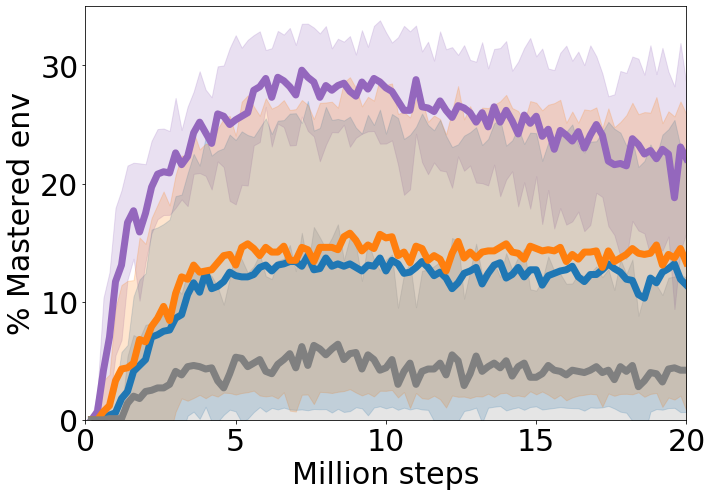

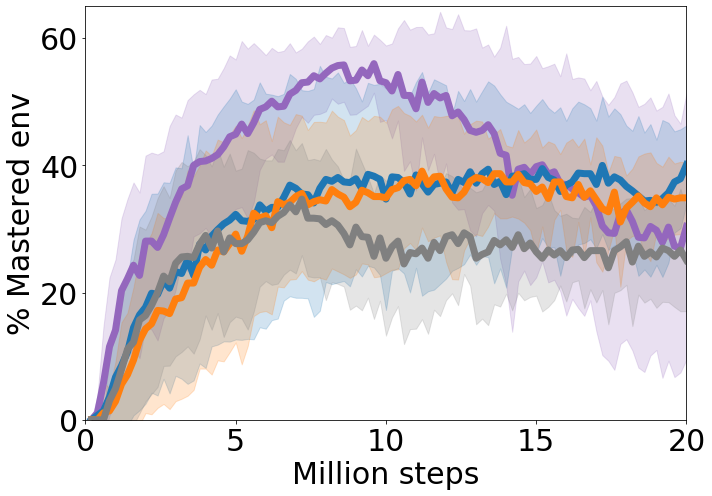

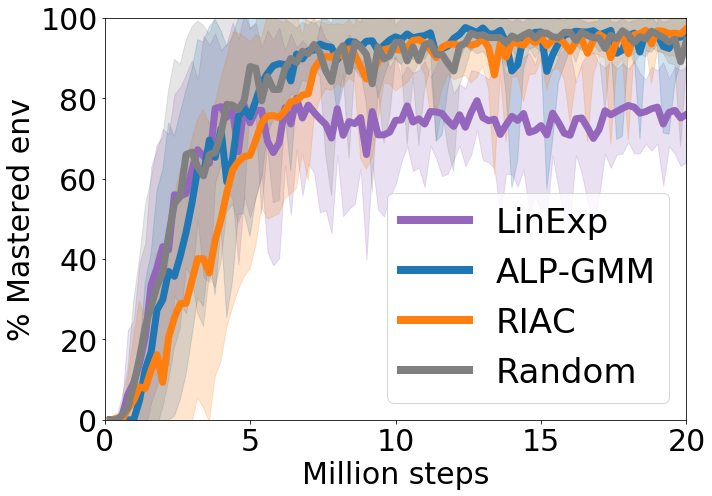

In [75]:
#PER AGENT PERFS SIMPLE EXPE
#order = ['oracle','gmm','riac','rand']
agent_types = ["short","default", "long"]
legend = [False, False, True]
y_max = [35,65,100]
plt.ion()
for k, a_type in enumerate(agent_types):
    f, ax = plt.subplots(1,1,figsize=(10,7))
    ax = [ax]
    for i,(m_id,label) in enumerate(labels.items()):
        if a_type in m_id:
            print(m_id)
            runs_data = models_saves[m_id]['data']
            ys = []
            for run in runs_data:  
                data = run['nb_mastered']
                print(run['config']['seed'])
                print("max:{} last:{}".format(max(data), data[-1]))
                #data = run['avg_pos_rewards']
                #data = run['local_rewards']
                #data = run['evaluation return']
                episodes = np.array(run['total timesteps'])
                ys.append(data)
            #clean data    
            min_len = 999999
            for y in ys:
                if len(y) < min_len:
                    
                    min_len = len(y)
            ys_same_len = []
            for y in ys:
                ys_same_len.append(y[0:min_len])
            episodes = episodes[0:min_len]
            episodes = [e/1000000 for e in episodes]
            #print(episodes)

#             plot_all_and_median(0, ax[0], episodes,ys_same_len,colors[m_id],label,
#                                 title="Median BW stump width/height/rotation/spacing {} agent".format(a_type), legend=True)
            plot_with_std(0, ax[0],episodes,np.mean(ys_same_len,axis=0),np.std(ys_same_len,axis=0),colors[m_id],colors[m_id],label,
                    legend=legend[k],ylim=[0,y_max[k]])
            plt.tight_layout()
            #f.savefig('graphics/all_perfs_{}_agents_mastered_envs.png'.format(a_type))

# perform welch tests:
for type0 in agent_types:
    for i0,(m_id0,label0) in enumerate(labels.items()):
        if type0 in m_id0 and 'gmm' in m_id0:
            for i1,(m_id1,label1) in enumerate(labels.items()):
                if type0 in m_id1:
                    pass
                    #for i in range(75,150):
                    #    get_welch(algo_0=m_id0, algo_1=m_id1, epoch=i)
                        
# get_welch(algo_0='gmmcontdefault08-06', algo_1="randcontdefault08-06")
# get_welch(algo_0='gmmcontshort07-06', algo_1="randcontshort07-06")
# get_welch(algo_0='gmmcontlong09-06', algo_1="randcontlong09-06")
# get_welch(algo_0='gmmcontdefault08-06', algo_1="riaccontdefault08-06")
# get_welch(algo_0='gmmpolylong17-06', algo_1='randpolylong17-06')
# get_welch(algo_0='gmmpolydefault17-06', algo_1='randpolydefault17-06')
# get_welch(algo_0=, algo_1='gmmpolylong17-06')
# get_welch(algo_0='gmmpolydefault17-06', algo_1='randpolydefault17-06')
        
plt.savefig("graphics/sac_sagg_vs_random_3_leg_sizes.png", bbox_inches='tight')

OrderedDict([('randplongcpu23-06', 'grey'), ('riacplongcpu22-06', '#ff7f0e'), ('gmmplongcpu22-06', '#1f77b4')])
gmmplongcpu22-06


KeyError: 'nb_mastered'

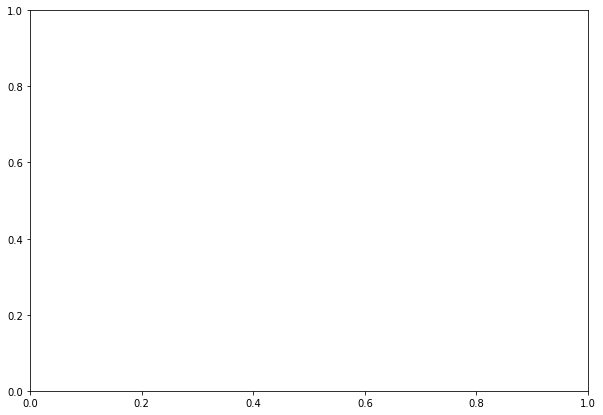

In [53]:
print(colors)
#Increasing stump height experience
#agent_types = ["cd","h4","h5"]
agent_types = ['pl']
plt.ion()
for a_type in agent_types:
    f, ax = plt.subplots(1,1,figsize=(10,7))
    ax = [ax]
    for i,(m_id,label) in enumerate(labels.items()):
        if a_type in m_id and 'bmm' not in m_id: #and 'oracle' not in m_id:
            print(m_id)
            runs_data = models_saves[m_id]['data']
            ys = []
            for run in runs_data:  
                #print(run['config']['seed'])
                data = run['nb_mastered']
                #data = run['evaluation return']
                episodes = np.array(run['total timesteps'])
                ys.append(data)
            #clean data    
            min_len = 999
            for y in ys:
                if len(y) < min_len:
                    
                    min_len = len(y)
            ys_same_len = []
            for y in ys:
                ys_same_len.append(y[0:min_len])
            episodes = episodes[0:min_len]
            episodes = [e/1000000 for e in episodes]
            #print(episodes)

            plot_all_and_median(0, ax[0], episodes,ys_same_len,colors[m_id],label,
                                 legend=True)
#             plot_with_std(0, ax[0],episodes,np.mean(ys_same_len,axis=0),
#                           np.std(ys_same_len,axis=0),colors[m_id],colors[m_id],label,
#                           legend=True,ylim=[0,100], xlim=[0,40])
            plt.tight_layout()
            #f.savefig('graphics/stump_height_{}_agents_mastered_envs.png'.format(a_type))
            #f.savefig('graphics/complex_{}_agents_mastered_envs.png'.format(a_type))

# perform welch tests:
for type0 in ['pl','cd','h4','h5']:
    for i0,(m_id0,label0) in enumerate(labels.items()):
        if type0 in m_id0 and 'riac' in m_id0:
            for i1,(m_id1,label1) in enumerate(labels.items()):
                if type0 in m_id1 and 'gmm' in m_id1:
                    get_welch(algo_0=m_id0, algo_1=m_id1, epoch=200)
#get_welch(algo_0='gmmp10longcpu228-06', algo_1='riacplongcpu328-06',epoch=200)
#get_welch(algo_0='gmmcdefaultcpu21-06', algo_1='gmmh5defaultcpu21-06')

In [ ]:
#single plot
plt.ion()
f, ax = plt.subplots(1,1,figsize=(10,7))
ax = [ax]
fm, axm = plt.subplots(1,1,figsize=(10,7))
axm = [axm]
for i,(m_id,label) in enumerate(labels.items()):
    #print(m_id)
    runs_data = models_saves[m_id]['data']
    #print(len(runs_data))
    ys = []
    for run in runs_data:  
        #print(list(run))
        data = run['nb_mastered']
        #data = run['AverageEpRet']
        #print(list(run))
        episodes = np.array(run['total timesteps'])
        #print(run['config']['seed'])
        #print(len(run['env_params_train']))
        #print(len(run['env_params_test']))
        ys.append(data)
        #clean data    
    min_len = 999999
    for y in ys:
        if len(y) < min_len:
            min_len = len(y)
    ys_same_len = []
    for y in ys:
        ys_same_len.append(y[0:min_len])
    episodes = episodes[0:min_len]
    episodes = [e/1000000 for e in episodes]
    
#     plot_all_and_median(0, ax[0], episodes,ys_same_len,colors[m_id],label,
#                         title="BW (stumps[0,3],spacing[0,6]) all levels", legend=True)
    #f.savefig('graphics/sac_sagg_vs_random_3_leg_sizes.png')
    plot_with_std(0, axm[0],episodes,np.mean(ys_same_len,axis=0),np.std(ys_same_len,axis=0),colors[m_id],colors[m_id],label,
                   legend=False,ylim=[0,55])

#get_welch(algo_0='saggcont02-05', algo_1="randcont02-05")
        
#plt.savefig("graphics/sac_sagg_vs_random_3_leg_sizes.png", bbox_inches='tight')

In [ ]:
# FOR GMM COMPLEX POLY ENV TASK SAMPLING VIZU
import gym
import gym_flowers
def poly_params_to_image(p):
    env = gym.make('flowers-Walker-continuous-v0')  # 4242 gap 42 stump #'flowers-Walker-v2''BipedalWalkerHardcore-v2''OGWalkerHardcore-v2'
    env.env.my_init({'leg_size': 'long'})
    env.env.set_environment(poly_shape=p)
    env.reset()
    img = env.render(mode='rgb_array')
    env.close()
    return img

def poly_2_stump_height(params):
    scaling = 14/30.0
    obstacle_polygon = [(-0.5,0),(-0.5,0.25),(-0.25,0.5),(0.25,0.5),(0.5,0.25),(0.5,0)]
    paired_params = [[params[i],params[i+1]] for i in range(0,len(params),2)]
    #print(paired_params)
    # first recover polygon coordinate
    poly_coord = []
    for i,(b,d) in enumerate(zip(obstacle_polygon, paired_params)):
        #print(paired_params)
        if i != 0 and i != (len(obstacle_polygon)-1):
            poly_coord.append([(b[0]*scaling) + (d[0]*scaling),
                              (b[1]*scaling) + (d[1]*scaling)])
        else:
            poly_coord.append([(b[0] * scaling) + (d[0]*scaling),
                               (b[1] * scaling)])
    # the find maximal width and height
    poly_coord = np.array(poly_coord)
    min_x = np.min(poly_coord[:,0])
    max_x = np.max(poly_coord[:,0])
    min_y = np.min(poly_coord[:,1])
    max_y = np.max(poly_coord[:,1])
    return [(max_x - min_x)/scaling, (max_y - min_y)/scaling]
        
def plt_2_rgb(ax):
    ax.figure.canvas.draw()
    data = np.frombuffer(ax.figure.canvas.tostring_rgb(), dtype=np.uint8)
    data = data.reshape(ax.figure.canvas.get_width_height()[::-1] + (3,))
    return data

import imageio

# def extract_env_params(env_goals, order=['poly_ss']):
#     #order = ['stump_hs', 'tunnel_hs']
#     if order == ['poly_ss']:
#         flat_env_params = copy.copy(env_goals[order[0]])
#         # map to 2d height and width
#         scaling = 14/30.0
#         obstacle_polygon = [(-0.5,0),(-0.5,0.25),(-0.25,0.5),(0.25,0.5),(0.5,0.25),(0.5,0)]
#         height_width_params = []
#         for params in flat_env_params:
#             height_width_params.append(poly_2_stump_height(params))
#         return height_width_params
# FIXED SET PERFS VIZU
size_test_set = 50
mastered_thr = 230
max_epochs = 100

stats = {}
for i,(m_id,label) in enumerate(labels.items()):
    if "gmmplong" not in m_id:
        continue
    print(m_id)
    runs_data = models_saves[m_id]['data']
    #collect raw perfs
    for r,run in enumerate(runs_data):
        if r is not 1:
            continue
        poly_tasks_dict = run['env_params_train']
        poly_tasks_list = [p for p in poly_tasks_dict['poly_ss']]
        poly_rewards = run['env_train_rewards']
        hw_tasks = np.array([poly_2_stump_height(p) for p in poly_tasks_list])
        plt.ion()
        
        print(len(run['means']))
        for j,m_vec in enumerate(run['means']):
            best_params = []
            best_lp = -1
            for p in m_vec:
                if p[-1] > best_lp:
                    best_params = p[:-1]
                    best_lp = p[-1]
            img = poly_params_to_image(best_params)
            plt.imsave('best_gmm({})_{}.png'.format(j,len(m_vec)), img)
#             plt.figure()
#             plt.imshow(img)
#         mean_rews = [np.mean(poly_rewards[i:i+250]) for i in range(250,len(poly_rewards),250)]
#         plt.plot(mean_rews)
#         plt.figure()
#         heatmap, xedges, yedges = np.histogram2d(hw_tasks[:30000,0], hw_tasks[:30000,1],
#                                                      bins=50,
#                                                     range=[[0,5],[0,5]])
#         extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

#         plt.imshow(heatmap.T, extent=extent, origin='lower')
#         plt.savefig("graphics/VIZUmiddle_{}_{}.png".format(m_id,runs_data[r]['config']['seed']))
#         plt.show()
        
        
        
        if False:
            start = 0
            end = 30000
            step = 250
            nb_points = 250
            images = []
            f, (ax0, ax1) = plt.subplots(1,2,figsize=(20,4))
            ax = (ax0, ax1)
            for k,i in enumerate(range(start,end,step)):
                ax0.plot(mean_rews[:k+1])
                ax0.set_ylim(top=300, bottom=-150)
                ax0.set_xlim(left=0, right=150)

                heatmap, xedges, yedges = np.histogram2d(hw_tasks[i:i+step,0], hw_tasks[i:i+step,1],
                                                         bins=20,
                                                        range=[[0,5],[0,5]])
                extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

                ax1.imshow(heatmap.T, extent=extent, origin='lower')

    #             print(i)
    #             plt.figure(figsize=(8,8))
    #             ax = plt.gca()

    #             for j in range(nb_points):
    # #                 print(poly_rewards[i+j])
    # #                 print(type(np.interp(poly_rewards[i+j],[-150,350],[0,1])))
    #                 #color = plt.cm.jet(np.interp(poly_rewards[i+j],[-150,350],[0,1]))
    # #                 print(color)
    # #                 print(type(color)
    #                 if poly_rewards[i+j] > 230:
    #                     ax.scatter(hw_tasks[i+j][0], hw_tasks[i+j][1],
    #                                c='green', s=50, zorder=2)
    #                 else:
    #                     ax.scatter(hw_tasks[i+j][0], hw_tasks[i+j][1],
    #                                c='red', s=50, zorder=2)

    #             ax.set_xlim(left=0,right=6)
    #             ax.set_ylim(top=6, bottom=0)
    #             ax.tick_params(axis='both', which='major', labelsize=20)
    #             ax.set_xlabel('hexagon width', fontsize=25)
    #             ax.set_ylabel('hexagon height', fontsize=25)
    #             ax.set_aspect('equal', 'box')
    #             plt.tight_layout()
    #             #plt.show()
                images.append(plt_2_rgb(plt.gca()))
    #             plt.close()
            imageio.mimsave('graphics/complex_{}_evo_42.gif'.format(m_id), images, duration=0.3)
        
        #plt.savefig("graphics/gmmcomplex_triptic_{}_{}.png".format(m_id,runs_data[r]['config']['seed']))

In [4]:
from param_env_utils.active_goal_sampling import SAGG_IAC
import matplotlib.patches as patches
from param_env_utils.imgep_utils.gep_utils import scale_vector
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import matplotlib.colorbar as cbar

def scatter_plot_gif(data,nb_steps=50, name='test', xlim=None, ylim=None, fs=(7,7)):
    plt.ioff()
    length = len(data)
    step_size = int(length / nb_steps)
    print("Making an exploration GIF of {} steps".format(nb_steps))
    filenames = []
    for i,max_episodes in enumerate(np.arange(step_size,length+step_size,step_size)):
        scatter_plot(data[0:max_episodes],
                     emph_data=data[max_episodes-step_size:max_episodes],
                     xlim=xlim, ylim=ylim, fs=fs)
        f_name = "graphics/gifs/scatter_{}.png".format(i)
        plt.xlim(xmin=xlim[0],xmax=xlim[1])
        plt.ylim(ymin=ylim[0],ymax=ylim[1])
        plt.savefig(f_name, bbox_inches='tight')
        plt.close(f)
        filenames.append(f_name)
    images = []
    for filename in filenames:
        images.append(imageio.imread(filename))
    imageio.mimsave('graphics/scatter_gif_{}.gif'.format(name), images, duration=0.3)


        
def scatter_plot(data, ax=None, emph_data=None, xlim=[0,2], ylim=[0,2],fs=(7,7)):
    #print(ylim)
    if ax is None:
        f, ax = plt.subplots(1,1,figsize=fs)
    Xs,Ys = [d[0] for d in data], [d[1] for d in data]
    if emph_data is not None:
        emphXs,emphYs = [d[0] for d in emph_data], [d[1] for d in emph_data]
    ax.plot(Xs,Ys,'r.',markersize=2)
    ax.set_xlim(xmin=xlim[0],xmax=xlim[1])
    ax.set_ylim(ymin=ylim[0],ymax=ylim[1])
    ax.axis('equal')
    if emph_data is not None:
        ax.plot(emphXs,emphYs,'b.',markersize=5)
    ax.set_xlabel('stump height', fontsize=20)
    ax.set_ylabel('spacing', fontsize=20)
        
def plot_regions(boxes, interests, ax=None, xlim=[0,2], ylim=[0,2]):
    # Create figure and axes
    if ax==None:             
        f, ax = plt.gca()
    # Add the patch to the Axes
    for b,ints in zip(boxes,interests):
        #print(b)
        lx,ly = b.low
        hx,hy = b.high
        c = plt.cm.jet(ints)
        rect = patches.Rectangle([lx,ly],(hx - lx),(hy - ly),linewidth=3,edgecolor='white',facecolor=c)
        ax.add_patch(rect)
        #plt.Rectangle([lx,ly],(hx - lx), (hy - ly))

    cax, _ = cbar.make_axes(ax) 
    cb = cbar.ColorbarBase(cax, cmap=plt.cm.jet) 
    cb.set_label('Mean Competence Progress')
    ax.set_xlim(xmin=xlim[0],xmax=xlim[1])
    ax.set_ylim(ymin=ylim[0],ymax=ylim[1])
    ax.axis('equal')
    ax.set_xlabel('stump height', fontsize=20)
    ax.set_ylabel('stump_spacing', fontsize=20)

def region_plot_gif(all_boxes, interests, iterations, goals,
                    gifname='saggriac', rewards=None, ep_len=None,
                    xlim=[0,2], ylim=[0,2], fs=(18,7), plot_step=250):
    plt.ioff()
    print("Making an exploration GIF: "+gifname)
    filenames = []
    images = []
    steps = []
    mean_rewards = []
    for i in range(len(goals)):
        if i>0 and (i%plot_step == 0):
            f, (ax0,ax1) = plt.subplots(1,2,figsize=fs)
            ax = [ax0,ax1]
            scatter_plot(goals[0:i], ax=ax[0], emph_data=goals[i-plot_step:i], xlim=xlim, ylim=ylim)
            idx = 0
            cur_idx = 0
            for j in range(len(all_boxes)):
                if iterations[j] > i:
                    break
                else:
                    cur_idx = j

#             #ADD TRAINING CURVE
#             ax[2].set_ylabel('Train return', fontsize=18)
#             steps.append(sum(ep_len[0:i]))
#             mean_rewards.append(np.mean(rewards[i-plot_step:i]))
#             ax[2].plot(steps,mean_rewards)
            
            plot_regions(all_boxes[cur_idx], interests[cur_idx],ax=ax[1], xlim=xlim, ylim=ylim)
            f_name = "graphics/gifs/scatter_{}.png".format(i)
            plt.suptitle('Episode {}'.format(i), fontsize=20)
            plt.savefig(f_name, bbox_inches='tight')
            plt.close(f)
            filenames.append(f_name)
    for filename in filenames:
        images.append(imageio.imread(filename))
    imageio.mimsave('graphics/{}.gif'.format(gifname), images, duration=0.3)

def extract_env_params(env_goals, order):
    #order = ['stump_hs', 'tunnel_hs']
    flat_env_params = copy.copy(env_goals[order[0]])
    nb_episodes = len(flat_env_params)
    if len(order) == 1:
        pass #work already done
    elif order == ['stump_hs', 'ob_sps']:
        for ep_nb in range(nb_episodes):
                flat_env_params[ep_nb][1] = env_goals['ob_sps'][ep_nb] #ignore variance 
    elif len(order) == 2:
        for ep_nb in range(nb_episodes):
            for i in range(1,len(order)):
                flat_env_params[ep_nb][1] = env_goals[order[i]][ep_nb][0] #ignore variance 
        print(env_goals[order[0]][0])
        print(env_goals[order[1]][1])
        print(flat_env_params[0])
    return flat_env_params

In [ ]:
#PLOT scatter plots
for i,(m_id,d) in enumerate(models_saves.items()):
    if 'long' not in m_id:
        continue
    if 'oracle' not in m_id:
        continue
    print(m_id)
    runs_data = d['data']

    for j,run in enumerate(runs_data):
        #print(j)
        d = run['env_params_train']
        print(d['stump_hs'][0])
        print(d['tunnel_hs'][0])
        print(d.keys())
        print(run['config']['seed'])
        order = []
        if d['stump_hs'][0]:
            order.append('stump_hs')
        if d['tunnel_hs'][0]:
            order.append('tunnel_hs')
        if d['ob_sps'][0]:
            order.append('ob_sps')
        print(order)
        
        scatter_plot(extract_env_params(d, order), xlim=[0,3], ylim=[0,6], fs=(4,8))
        plt.show()
            
#         scatter_plot_gif(extract_env_params(d, order),
#                           name='{}{}'.format(m_id, j), xlim=[0,2], ylim=[0,6])


In [ ]:
# Triptic GMM and RIAC plots
import param_env_utils.imgep_utils.plot_utils as plotter
import importlib
importlib.reload(plotter)
save_dir = 'graphics/'
gmm_seed = 0
gmm_iterations = [500, 1500, 15000]
no_y = [True, True, False]
bars = [True,False,False]

riac_iterations = [1000,2250,7000,12000]
riac_bars = [False, False, False, True]
riac_nb = 2

#scatter_plot(env_goals)
for model_name,_ in models_saves.items():
    if not "default" in model_name:
        continue
    print(models_saves[model_name]['data'][0]['config']['env_babbling'])
    #print(models_saves[sagg_model_name]['data'][0]['config']['seed'])
    if models_saves[model_name]['data'][0]['config']['env_babbling'] == 'sagg_riac':
        all_boxes = models_saves[model_name]['data'][riac_nb]['all_boxes']

        #for boxes in all_boxes:
        #    print(boxes)
        split_iterations = models_saves[model_name]['data'][riac_nb]['split_iterations']
        env_train_rewards = models_saves[model_name]['data'][riac_nb]['env_train_rewards']
        all_interests = models_saves[model_name]['data'][riac_nb]['all_interests']
        env_goals = models_saves[model_name]['data'][riac_nb]['env_params_train']
        ep_len = models_saves[model_name]['data'][riac_nb]['env_train_len']
        order = []
        if env_goals['stump_hs'][0]:
            order.append('stump_hs')
        if env_goals['ob_sps'][0]:
            order.append('ob_sps')
        if len(env_goals) >= 2:
            env_goals = extract_env_params(env_goals, order)
            print(len(env_goals))

        if len(all_boxes) == 0:
            print('abort {}'.format(i))
            continue
        print(len(env_goals))
        name='triptic_RIAC_'+ model_name +str(i)
        rewards=env_train_rewards,
        ep_len=ep_len
        xlim=[0,3]
        ylim=[0,6]
        fs=(16,8)
        plot_step = 1000
        interests = all_interests
        iterations = split_iterations
        goals = env_goals

        filenames = []
        images = []
        steps = []
        mean_rewards = []
        plot_step = 250
        cpt=-1
        for i in range(len(goals)):
            if i > 0 and (i % plot_step == 0) and i in riac_iterations:
                cpt+=1
                f, ax = plt.subplots(1, 1, figsize=(5, 8))
                #plotter.scatter_plot(goals[0:i], ax=ax[0], emph_data=goals[i - plot_step:i], xlim=xlim, ylim=ylim)
                idx = 0
                cur_idx = 0
                for j in range(len(all_boxes)):
                    if iterations[j] > i:
                        break
                    else:
                        cur_idx = j
                print(j)
                plotter.plot_regions(all_boxes[cur_idx], interests[cur_idx], ax=ax, xlim=xlim,
                                     ylim=ylim, bar=riac_bars[cpt])

                #f_name = gifdir+tmpdir+"scatter_{}.png".format(i)
                f_path = save_dir + name +"_{}.png".format(i)
                #plt.suptitle('Episode {}'.format(i), fontsize=20)
                plt.savefig(f_path, bbox_inches='tight')
                plt.show()
                    
    elif models_saves[model_name]['data'][0]['config']['env_babbling'] == 'gmmlkjh':
        #plt.ioff()
        bk = models_saves[model_name]['data'][gmm_seed]
        name='triptic_GMM_'+str(gmm_seed)
        xlim=[0,3]
        ylim=[0,6]
        
        old_ep = 0
        gen_size = int(len(bk['goals_lps']) / len(bk['episodes']))
        gs_lps = bk['goals_lps']
        cpt = -1
        for i,(ws, covs, means, ep) in enumerate(zip(bk['weights'], bk['covariances'], bk['means'], bk['episodes'])):
                if ep not in gmm_iterations:
                    continue
                cpt += 1
                fig_size = (4,8)
                if bars[cpt]:
                    fig_size = (5,8)
                    
                plt.figure(figsize=fig_size)
                ax = plt.gca()
                print(no_y[cpt])
                plotter.plot_gmm(ws, means, covs, np.array(gs_lps[ep:ep+gen_size]),
                         ax=ax, xlim=xlim, ylim=ylim, no_y=no_y[cpt],
                         bar=bars[cpt],bar_side='left')  #add gen_size to have gmm + the points that they generated, not they fitted
                f_path = save_dir + name +"_{}.png".format(ep)
                old_ep = ep
                plt.savefig(f_path, bbox_inches='tight')
                plt.show()

        # fig sizes: normal: (4.5,8) + 
        


In [33]:
import param_env_utils.imgep_utils.plot_utils as plotter
import importlib
importlib.reload(plotter)
# GIF for algorithms

#scatter_plot(env_goals)
for model_name,_ in models_saves.items():
#     if not "default" in model_name:
#         continue
    print(models_saves[model_name]['data'][0]['config']['env_babbling'])
    #print(models_saves[sagg_model_name]['data'][0]['config']['seed'])
    if models_saves[model_name]['data'][0]['config']['env_babbling'] == 'sagg_riac':
        for i in range(len(models_saves[model_name]['data'])):
            all_boxes = models_saves[model_name]['data'][i]['all_boxes']

            #for boxes in all_boxes:
            #    print(boxes)
            split_iterations = models_saves[model_name]['data'][i]['split_iterations']
            env_train_rewards = models_saves[model_name]['data'][i]['env_train_rewards']
            all_interests = models_saves[model_name]['data'][i]['all_interests']
            env_goals = models_saves[model_name]['data'][i]['env_params_train']
            ep_len = models_saves[model_name]['data'][i]['env_train_len']
            #print(len(all_boxes))
            #print(len(split_iterations))
            #print(list(env_goals))
            #print(env_goals['stump_hs'][0])
            order = []
            if env_goals['stump_hs'][0]:
                order.append('stump_hs')
            if env_goals['tunnel_hs'][0]:
                order.append('tunnel_hs')
            if env_goals['ob_sps'][0]:
                order.append('ob_sps')
            if len(env_goals) >= 2:
                env_goals = extract_env_params(env_goals, order)
                print(len(env_goals))

            if len(all_boxes) == 0:
                print('abort {}'.format(i))
                continue
            print(len(env_goals))
            plotter.region_plot_gif(all_boxes, all_interests, split_iterations, env_goals,
                           gifname='SAGG_'+ model_name +str(i), rewards=env_train_rewards,
                            ep_len=ep_len, xlim=[0,3], ylim=[0,6], fs=(5,8),
                           plot_step = 250)
    elif models_saves[model_name]['data'][0]['config']['env_babbling'] == 'gmm':
        for i in range(len(models_saves[model_name]['data'])):
            bk = models_saves[model_name]['data'][i]
            # fig sizes: normal: (4.5,8) + 
            plotter.gmm_plot_gif(models_saves[model_name]['data'][i], gifname='GMM_'+ model_name +str(i),
                                xlim=[0,3],ylim=[0,6], fig_size = (5,8), save_imgs=True, title=True, bar=True,
                                gifdir='graphics/')


random
sagg_riac
14831
14831
Making an exploration GIF: SAGG_riaccontdefaultcpu21-060
Directory  graphics/tmp/  already exists
13963
13963
Making an exploration GIF: SAGG_riaccontdefaultcpu21-061
Directory  graphics/tmp/  already exists
14900
14900
Making an exploration GIF: SAGG_riaccontdefaultcpu21-062
Directory  graphics/tmp/  already exists
16894
16894
Making an exploration GIF: SAGG_riaccontdefaultcpu21-063
Directory  graphics/tmp/  already exists
16540
16540
Making an exploration GIF: SAGG_riaccontdefaultcpu21-064
Directory  graphics/tmp/  already exists
16814
16814
Making an exploration GIF: SAGG_riaccontdefaultcpu21-065
Directory  graphics/tmp/  already exists
18006
18006
Making an exploration GIF: SAGG_riaccontdefaultcpu21-066
Directory  graphics/tmp/  already exists
15487
15487
Making an exploration GIF: SAGG_riaccontdefaultcpu21-067
Directory  graphics/tmp/  already exists
15790
15790
Making an exploration GIF: SAGG_riaccontdefaultcpu21-068
Directory  graphics/tmp/  already 

28673
28673
Making an exploration GIF: SAGG_riaccontlongcpu21-066
Directory  graphics/tmp/  already exists
27497
27497
Making an exploration GIF: SAGG_riaccontlongcpu21-067
Directory  graphics/tmp/  already exists
28301
28301
Making an exploration GIF: SAGG_riaccontlongcpu21-068
Directory  graphics/tmp/  already exists
26703
26703
Making an exploration GIF: SAGG_riaccontlongcpu21-069
Directory  graphics/tmp/  already exists
29237
29237
Making an exploration GIF: SAGG_riaccontlongcpu21-0610
Directory  graphics/tmp/  already exists
31772
31772
Making an exploration GIF: SAGG_riaccontlongcpu21-0611
Directory  graphics/tmp/  already exists
28178
28178
Making an exploration GIF: SAGG_riaccontlongcpu21-0612
Directory  graphics/tmp/  already exists
30202
30202
Making an exploration GIF: SAGG_riaccontlongcpu21-0613
Directory  graphics/tmp/  already exists
32966
32966
Making an exploration GIF: SAGG_riaccontlongcpu21-0614
Directory  graphics/tmp/  already exists
29535
29535
Making an exploratio

![](graphics/exploration0.gif)
![](graphics/exploration1.gif)


![SegmentLocal](graphics/gmm0.gif "competence")
![SegmentLocal](graphics/onlineSAGGbignet0.gif "competence")
![SegmentLocal](graphics/onlineSAGGbignet1.gif "competence")
![SegmentLocal](graphics/onlineSAGGbignet2.gif "competence")
![SegmentLocal](graphics/onlineSAGGbignet3.gif "competence")
![SegmentLocal](graphics/onlineSAGGbignet4.gif "competence")
![SegmentLocal](graphics/onlineSAGGbignet5.gif "competence")

In [ ]:
lidar = []
self.lidar[i].fraction = 1.0
            self.lidar[i].p1 = pos
            self.lidar[i].p2 = (
                pos[0] + math.sin(1.5*i/10.0)*LIDAR_RANGE,
                pos[1] - math.cos(1.5*i/10.0)*LIDAR_RANGE)

gmmcdefaultcpu21-06
last:38.0, max:52.0


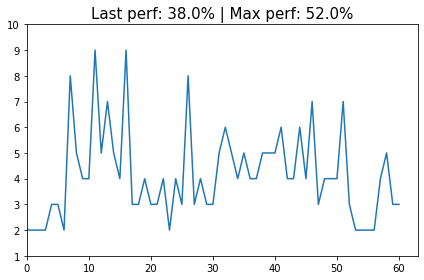

last:44.0, max:58.0


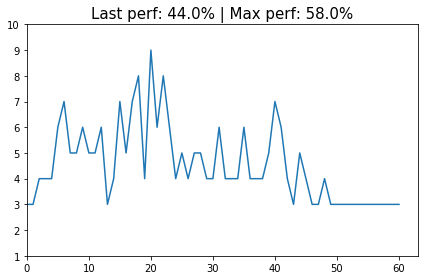

last:50.0, max:56.0


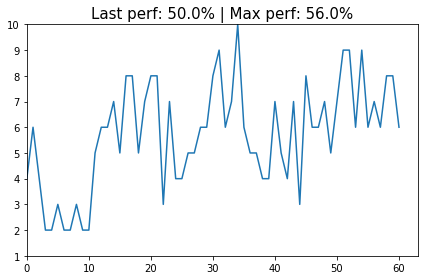

last:44.0, max:50.0


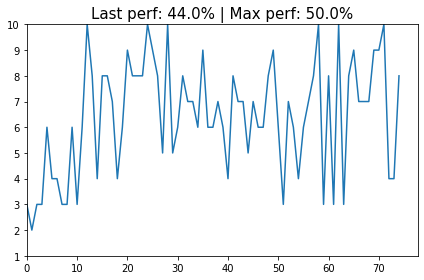

last:46.0, max:48.0


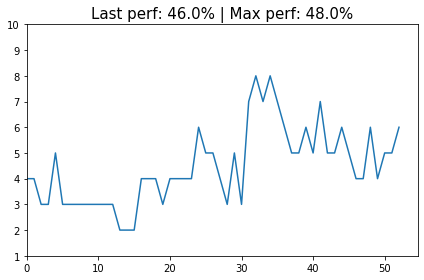

last:40.0, max:44.0


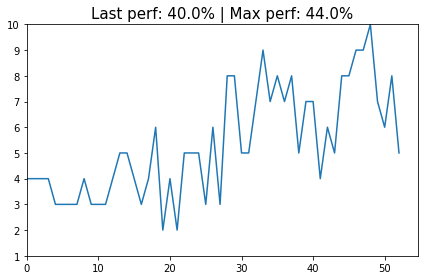

last:36.0, max:54.0


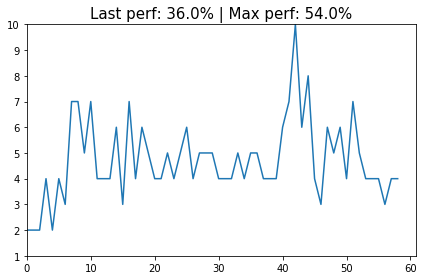

last:40.0, max:48.0


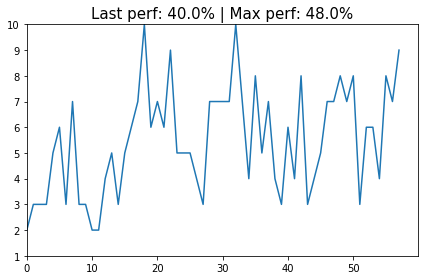

last:38.0, max:52.0


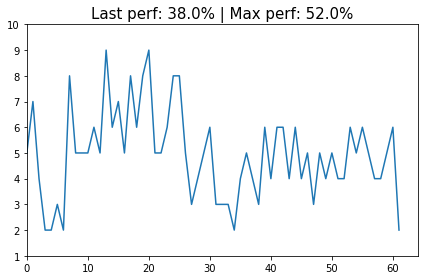

last:48.0, max:54.0


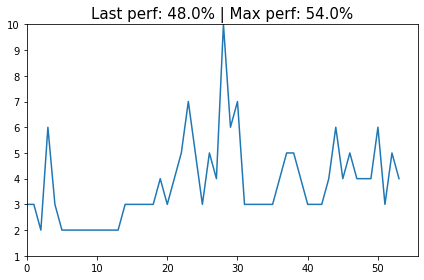

last:30.0, max:56.0


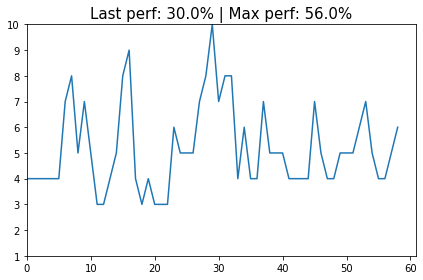

last:42.0, max:44.0


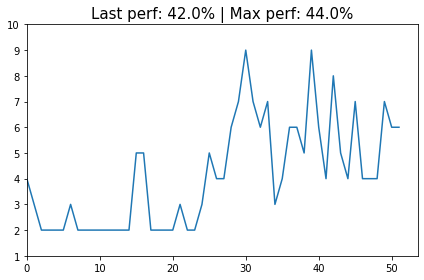

last:28.0, max:48.0


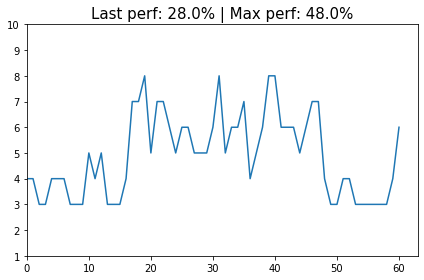

last:42.0, max:54.0


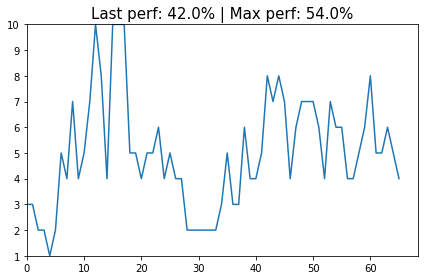

last:26.0, max:26.0


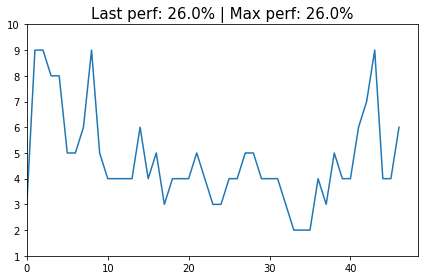

last:42.0, max:56.0


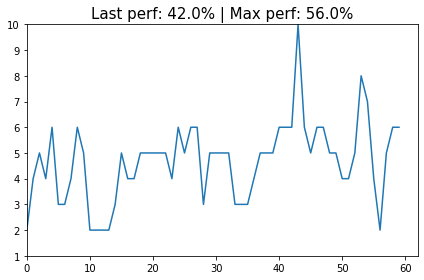

last:38.0, max:50.0


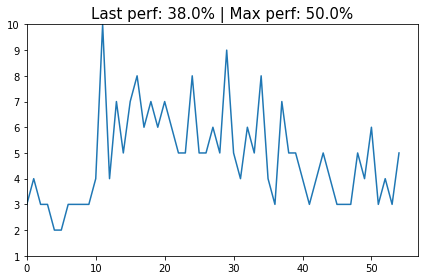

last:46.0, max:58.0


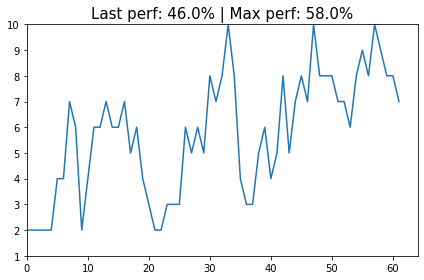

last:40.0, max:50.0


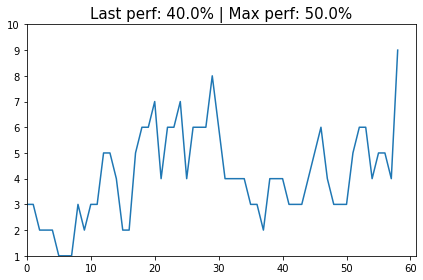

last:44.0, max:54.0


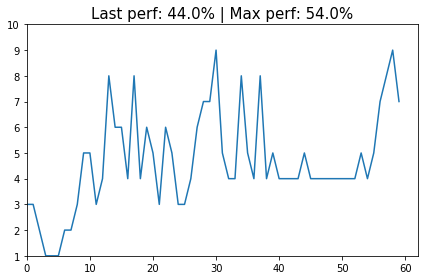

gmmcshortcpu21-06
last:0.0, max:0.0


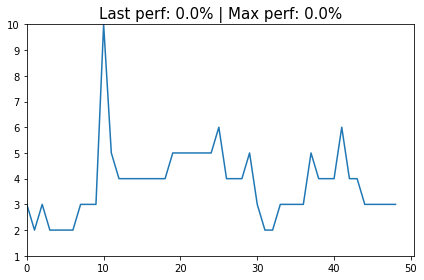

last:26.0, max:28.0


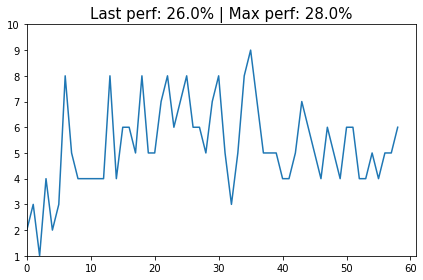

last:0.0, max:0.0


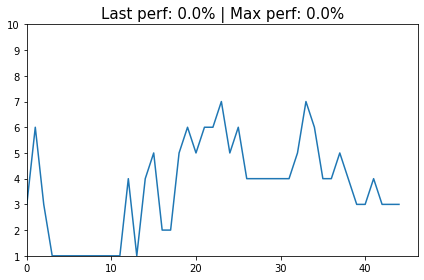

last:0.0, max:0.0


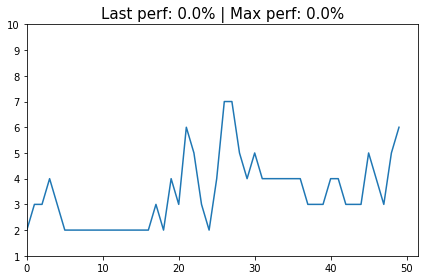

last:0.0, max:0.0


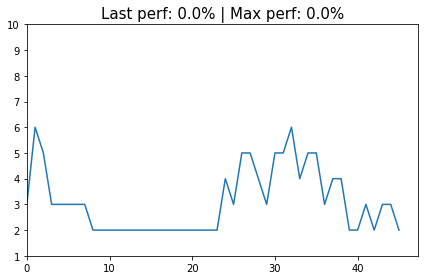

last:0.0, max:0.0


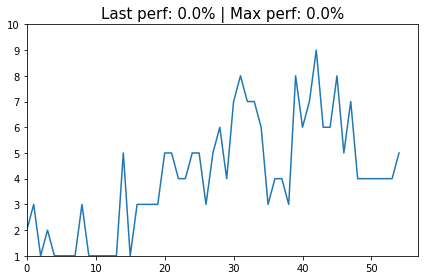

last:0.0, max:0.0


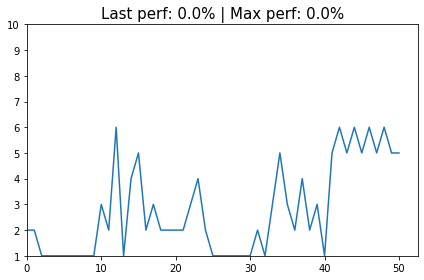

last:22.0, max:30.0


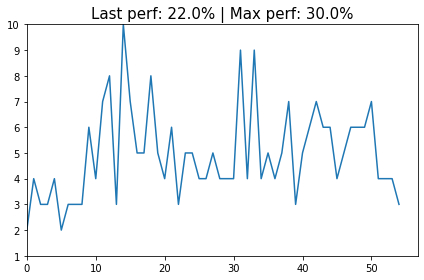

last:22.0, max:30.0


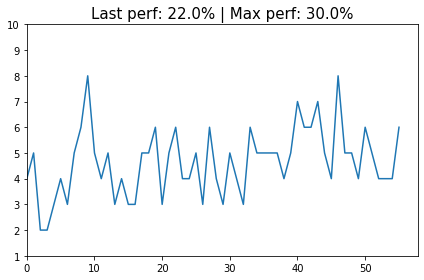

last:0.0, max:0.0


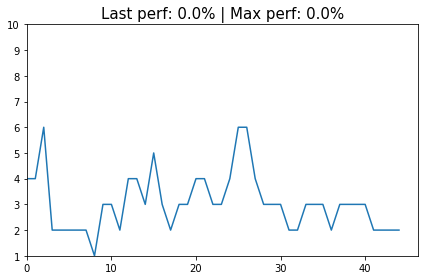

last:22.0, max:28.0


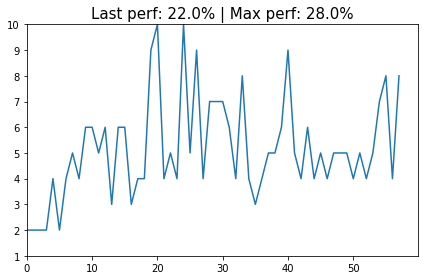

last:20.0, max:34.0


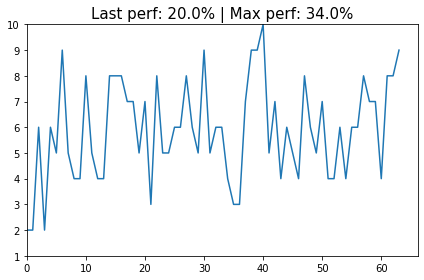

last:0.0, max:0.0


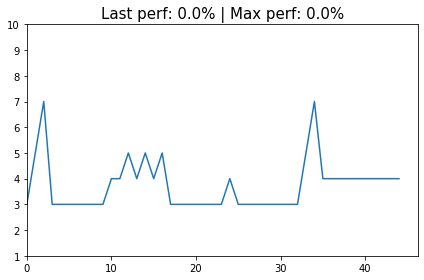

last:26.0, max:32.0


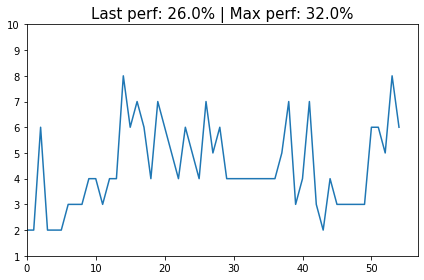

last:16.0, max:24.0


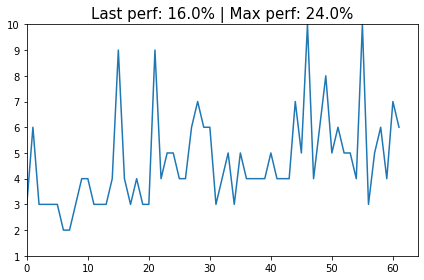

last:20.0, max:34.0


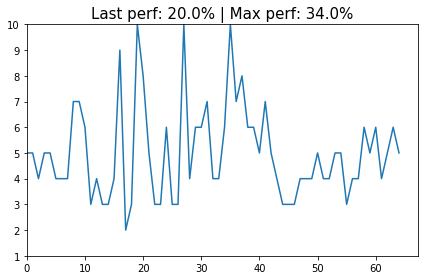

last:0.0, max:0.0


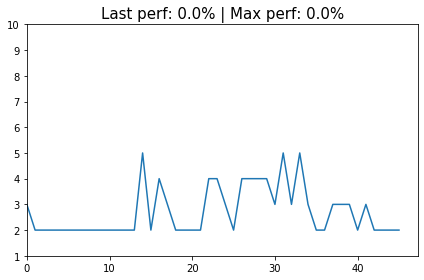

last:18.0, max:32.0


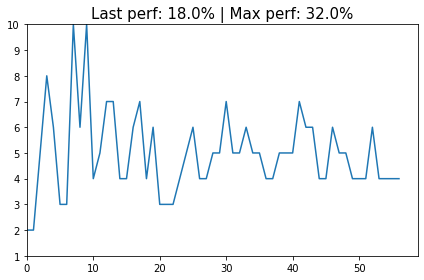

last:12.0, max:32.0


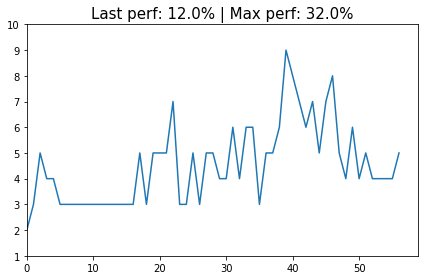

last:24.0, max:30.0


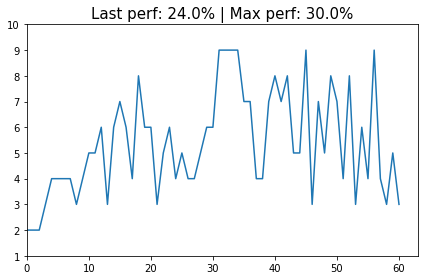

gmmclongcpu21-06
last:96.0, max:100.0


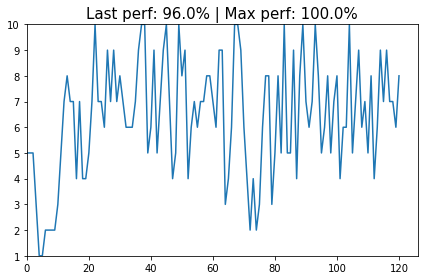

last:98.0, max:100.0


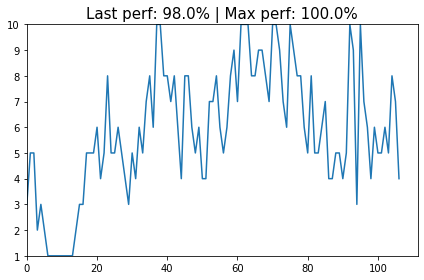

last:98.0, max:100.0


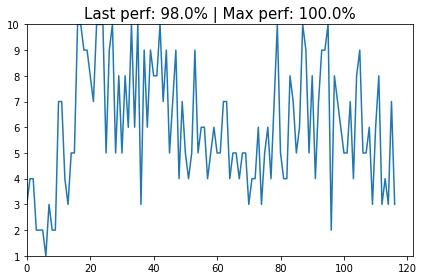

last:100.0, max:100.0


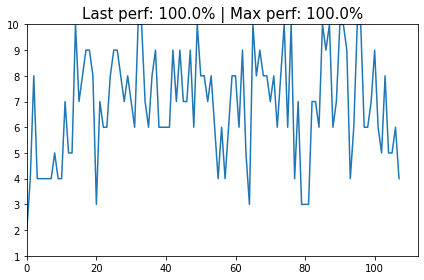

last:96.0, max:100.0


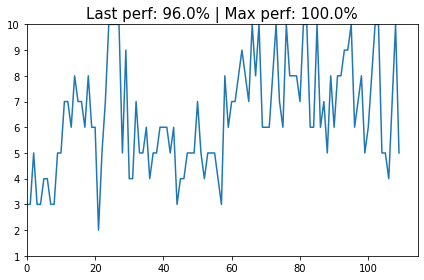

last:100.0, max:100.0


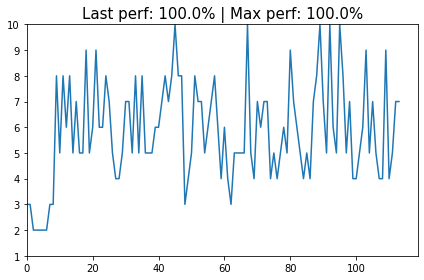

last:100.0, max:100.0


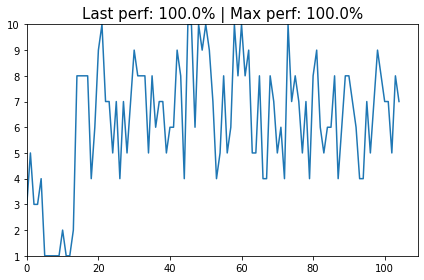

last:98.0, max:100.0


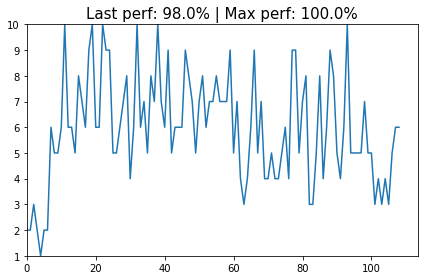

last:94.0, max:100.0


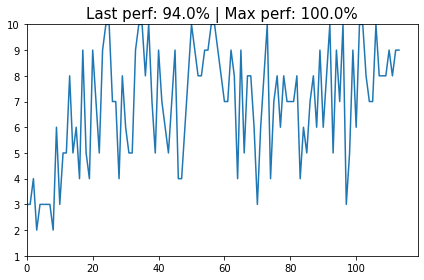

last:100.0, max:100.0


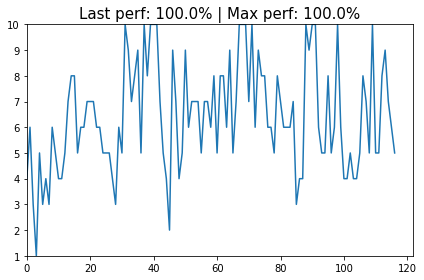

last:96.0, max:100.0


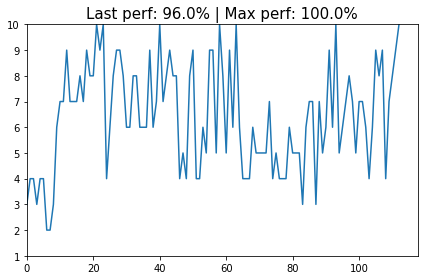

last:70.0, max:100.0


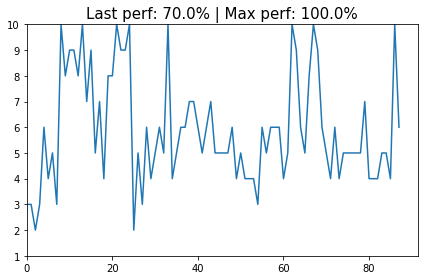

last:100.0, max:100.0


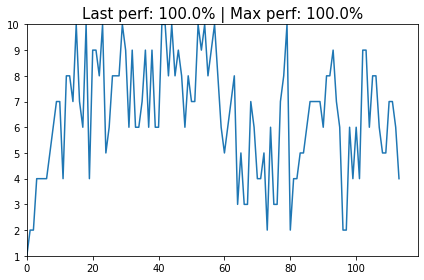

last:98.0, max:100.0


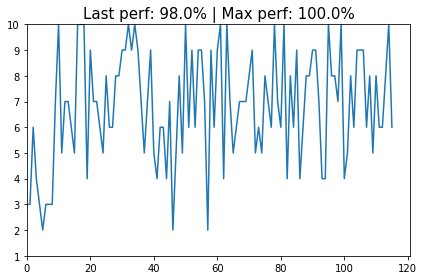

last:100.0, max:100.0


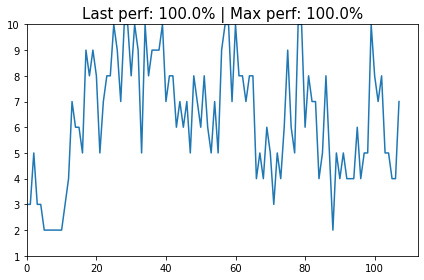

last:98.0, max:100.0


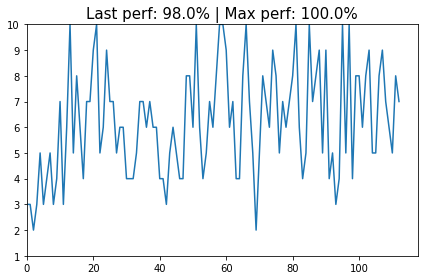

last:96.0, max:100.0


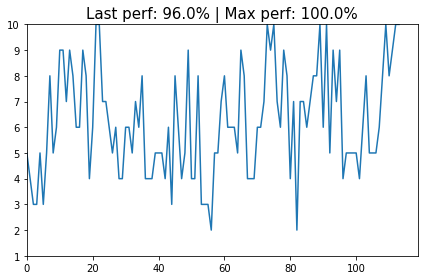

last:98.0, max:100.0


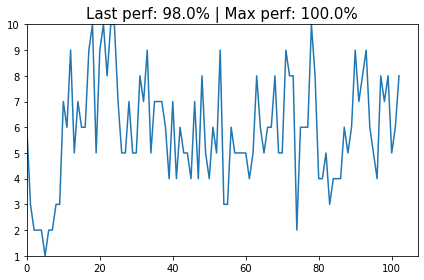

last:98.0, max:100.0


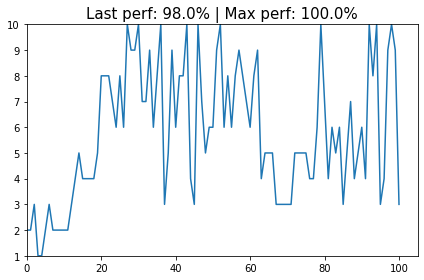

last:100.0, max:100.0


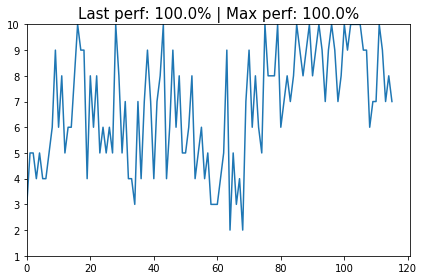

In [69]:
# PLOT EVOLUTION OF GMM's NUMBER OF GAUSSIANS
for i,(m_id,label) in enumerate(labels.items()):
    if "gmm" not in m_id:
        continue
    print(m_id)
    #print(m_id)
    runs_data = models_saves[m_id]['data']
    #print(len(runs_data))
    ys = []
    for j,run in enumerate(runs_data): 
            last_perf = round(run["nb_mastered"][-1],1)
            max_perf = round(max(run["nb_mastered"]),1)
            perf_str = "last:{}, max:{}".format(last_perf, max_perf)
            title = "Last perf: {}% | Max perf: {}%".format(last_perf, max_perf)
            print(perf_str)
            ax = plt.gca()
            nb_gauss = []
            for means in run['means']:
                nb_gauss.append(len(means))
            ax.plot(nb_gauss)
            ax.set_xlim(left=0)
            ax.set_ylim(top=10,bottom=1)
            
            ax.set_title(title, fontsize=15)
            plt.tight_layout()
            plt.savefig("graphics/nb_gaussians/{}{}_{}.png"
                        .format(m_id, j, perf_str))
            plt.show()
            plt.close()
            
        